In [33]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.dates as mdates
from portfolio_utils import *
# import ace_tools as tools; 

# 配置中文字体
plt.rcParams['font.family'] = 'Heiti TC'

# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 12})

In [34]:
#### 按照排序分配权重的策略
# 初始分配权重
def initial_weights(stock_symbols):
    num_stocks = len(stock_symbols)
    return np.ones(num_stocks) / num_stocks

# 重新分配权重
def rebalance_weights(z_scores, date, initial_weight):
    ranked_stocks = z_scores.loc[date].sort_values()
    num_stocks = len(ranked_stocks)
    new_weights = np.zeros(num_stocks)
    
    # 根据排序结果重新分配权重
    for i, stock in enumerate(ranked_stocks.index):
        new_weights[i] = initial_weight * (1 + ranked_stocks.index.get_loc(stock) / num_stocks)
    new_weights /= new_weights.sum()  # 归一化权重

    return new_weights

def rebalance_rank_portfolio(stock_prices, window, initial_capital):
    transaction_cost=0.005
    lot_size=100
    min_trade_volume = 200
    z_scores = calculate_z_score(stock_prices, window)
    
    num_stocks = len(stock_prices.columns)
    initial_weight = 1 / num_stocks
    weights = initial_weights(stock_prices.columns)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    positions[0] = current_positions
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year

    for t, date in enumerate(stock_prices.index[window:], start=1):
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score排序重新分配权重
        new_weights = rebalance_weights(z_scores, date, initial_weight)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1

        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
        
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count

In [35]:
### 按照Portfolio Optimization分配权重
def rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma=None, long_ma=None):
    lot_size=100
    transaction_cost = 0.005
    min_trade_volume = 100
    
    num_stocks = len(stock_prices.columns)
    z_scores = calculate_z_score(stock_prices, window)
    cov_matrix = stock_prices.pct_change().cov()
    mean_returns = stock_prices.pct_change().mean()
    dynamic_thresholds = dynamic_threshold(SSINDX, window)

    weights = portfolio_optimization(mean_returns, cov_matrix)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year
    
    positions[0] = current_positions

    for t, date in enumerate(stock_prices.index[window:], start=1):
        # 获取当前交易日的动态阈值
        threshold = dynamic_thresholds.loc[date]
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score和趋势调整权重
        new_weights = np.zeros(len(weights))
        for i, stock in enumerate(stock_prices.columns):
            if short_ma[stock].loc[date] > long_ma[stock].loc[date]:  # 确保在多头市场
                if z_scores[stock].loc[date] < -threshold:
                    new_weights[i] = weights[i] + 0.01
                elif z_scores[stock].loc[date] > threshold:
                    new_weights[i] = weights[i] - 0.01
                else:
                    new_weights[i] = weights[i]
            else:
                new_weights[i] = weights[i]  # 保持不变
                
        
        new_weights = np.clip(new_weights, 0, 1)
        new_weights = new_weights / np.sum(new_weights)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
                    adjustments[t, i] = 1 # 买入信号
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1
                    adjustments[t, i] = -1  # 卖出信号
            else: adjustments[t, i] = 0  # 卖出信号
    
        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
    
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count


In [36]:
# 读取Excel文件
df = pd.read_excel('Stocks.xlsx', sheet_name='Holdlist')

# 获取股票代码列表
stock_symbols = df['Stock Symbol'].tolist()
stock_names = df['Stock Name'].tolist()

# 定义时间范围
start_date = '2022-01-01'
# start_date = '2024-06-01'
end_date = '2024-08-27'

# 设置参数
#initial_capital = 34000
initial_capital = 37000
window = 10
threshold = 2.5
transaction_cost = 0.005  # 假设交易成本为0.5%
rebalance_period = 7  # 调仓周期为3天

stock_data = get_stock_price(stock_symbols, start_date, end_date)
# stock_data = get_stock_price()
# 获取上证指数数据
SSINDX = yf.download('000001.SS', start_date, end_date)['Close']

# Ensure stock_data is a DataFrame and handle any missing values
stock_prices = pd.DataFrame(stock_data).ffill().bfill()
dates = stock_prices.index[window-1:]
short_window = 40
long_window = 200
short_ma, long_ma = calculate_moving_average(stock_prices, short_window, long_window)

# 调整rebalance_portfolio函数的调用
portfolio_values, weights, positions, adjustments, buy_count, sell_count = rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma, long_ma)
portfolio_values1, weights1, positions1, adjustments1, buy_count1, sell_count1 = rebalance_rank_portfolio(stock_prices=stock_prices, window=window, initial_capital=initial_capital)
benchmark = SSINDX / SSINDX.iloc[0] * portfolio_values[0]
print(f'Final Portfolio Value: {portfolio_values[-1]}')
print(f'Final Portfolio Value: {portfolio_values1[-1]}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Final Portfolio Value: 59321.78357359767
Final Portfolio Value: 58255.93295365572


In [37]:
# Total PnL Summary
summary_total = pnl_summary_total(portfolio_values, dates, positions, stock_prices, window=window)
summary_total

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,60.33,19.84,1.3,10.8,1.59,1.64


In [38]:
summary_total1 = pnl_summary_total(portfolio_values1, dates, positions1, stock_prices,window=window)
summary_total1

,Total Return %,Annualized Return %,Sharpe Ratio,Max Drawdown %,Turnover %,Fitness
0,57.45,19.01,1.2,10.95,1.51,1.48


In [39]:
# PnL Summary of Portfolio Optimization
summary = pnl_summary(portfolio_values, dates, buy_count, sell_count)
summary

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,37000.0,40382.02,0.01,9.14,0.52,9.80,74,26
2023,40837.5,46841.17,0.01,14.70,1.32,5.47,61,44
2024,47448.9,59321.78,0.01,25.02,1.42,10.80,76,51


In [40]:
# PnL Summary of Rank Method
summary1 = pnl_summary(portfolio_values1, dates, buy_count1, sell_count1)
summary1

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2022,37000.00,40068.57,0.01,8.29,0.45,10.95,40,3
2023,40578.35,45908.08,0.01,13.13,1.13,5.68,3,10
2024,46453.75,58255.93,0.01,25.41,1.35,10.08,20,15


### PnL Visualization

In [41]:
# Interactive Plot for Portfolio Value
pnl_visualization(dates=dates, portfolio_values=portfolio_values, benchmark=benchmark)

In [42]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values1, mode='lines', name='Portfolio Value'))
fig.add_trace(go.Scatter(x=dates, y=benchmark, mode='lines',name='SSINDX PnL'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value', hovermode='x unified')
fig.show()

### Visualization

In [43]:
plot_historical_positions(dates, positions, stock_names, stock_prices, window=window)

In [44]:
plot_historical_positions(dates, positions1, stock_names, stock_prices, window=window)

In [45]:
plot_current_positions(weights, stock_names)

In [46]:
plot_current_positions(weights1, stock_names)

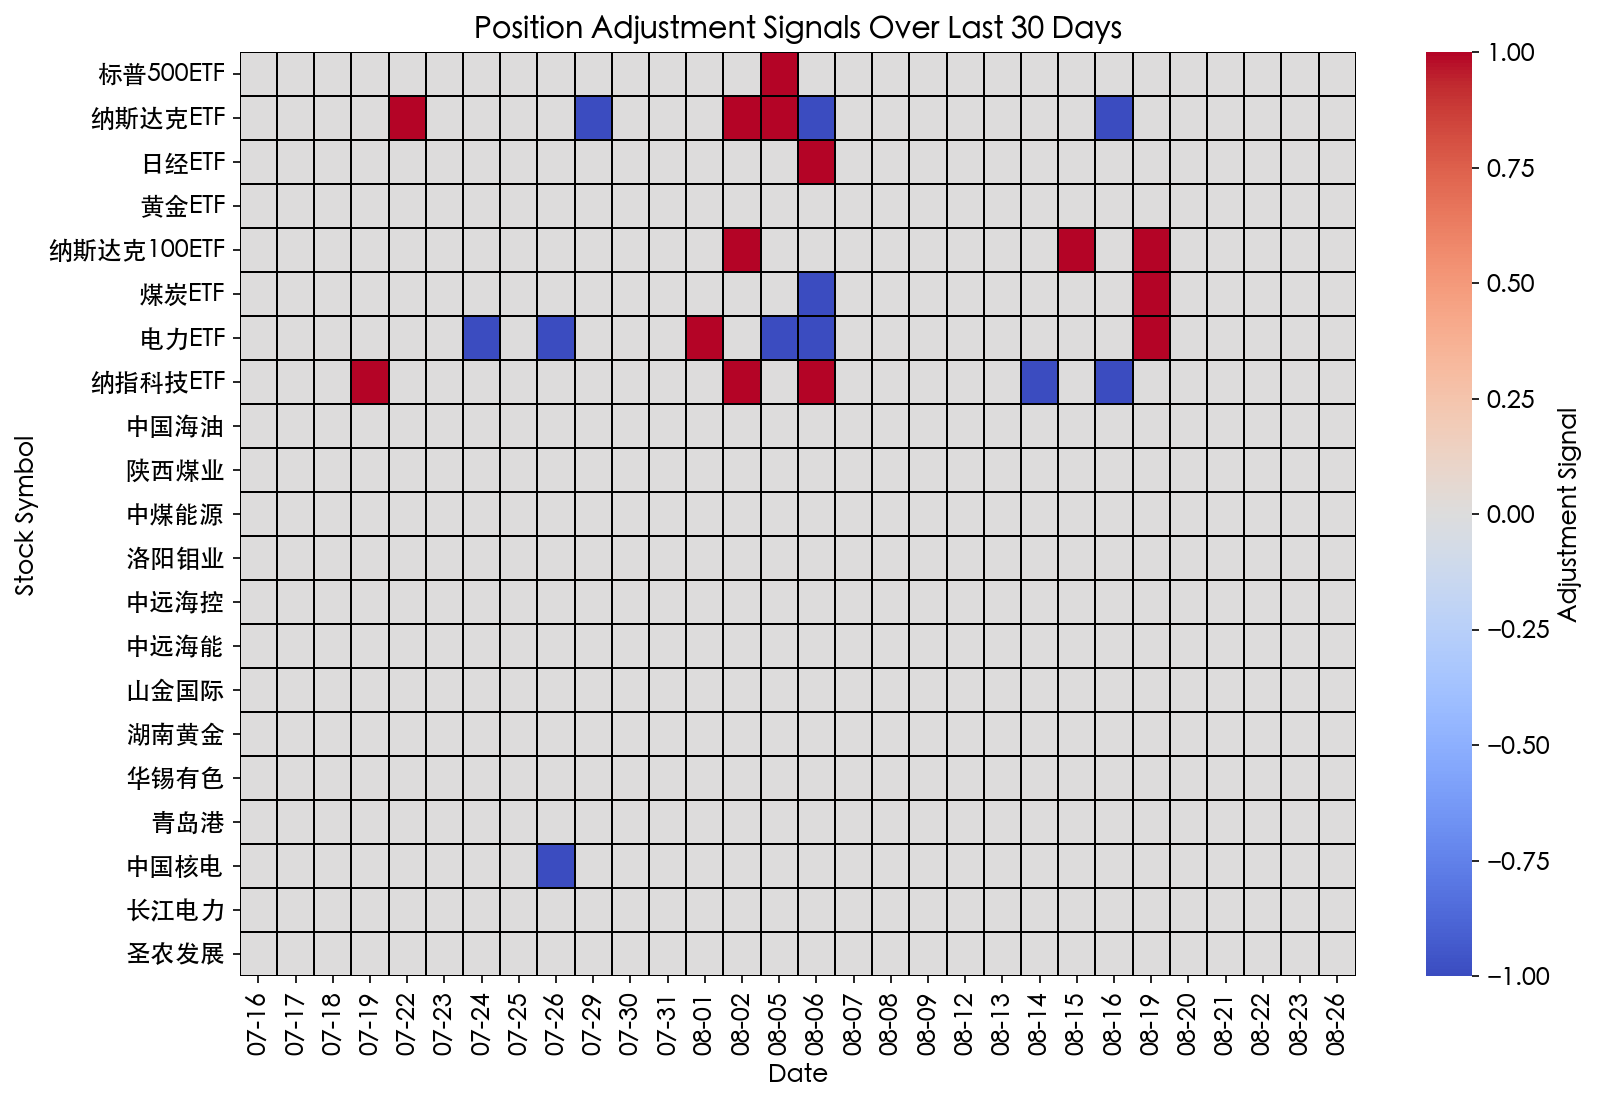

In [47]:
plot_adjustment_heatmap(dates, adjustments, stock_names)

In [48]:
position_table = display_position_table(stock_names, positions, stock_prices, adjustments, transaction_cost=transaction_cost)
print(dates[-1])
print(f'今日盈亏：{round(portfolio_values[-1] - portfolio_values[-2], 2)}, 盈亏比例：{round((portfolio_values[-1] - portfolio_values[-2])/portfolio_values[-1] * 100, 2)}%')
position_table

2024-08-26 00:00:00
今日盈亏：249.8, 盈亏比例：0.42%


,Stock Name,Holding,PnL Today,PnL Total,Y_Weight (%),T_Weight (%),Adjustment Signal,Weight Change (%)
159509.SZ,纳指科技ETF,3200,-6.4,1869.14,8.57,8.53,0.0,-0.05
601298.SS,青岛港,500,125.0,2279.07,8.02,8.20,0.0,0.18
513300.SS,纳斯达克ETF,2600,-36.4,1353.77,8.28,8.18,0.0,-0.10
513110.SS,纳斯达克100ETF,2300,2.3,1414.24,6.32,6.30,0.0,-0.02
002299.SZ,圣农发展,300,42.0,-3290.62,6.09,6.13,0.0,0.05
159611.SZ,电力ETF,3300,-13.2,87.14,5.61,5.56,0.0,-0.05
600301.SS,华锡有色,200,26.0,729.88,5.42,5.44,0.0,0.02
002155.SZ,湖南黄金,200,4.0,1133.89,5.39,5.37,0.0,-0.02
513500.SS,标普500ETF,1600,22.4,831.38,5.33,5.34,0.0,0.02
600900.SS,长江电力,100,-9.0,897.49,5.07,5.03,0.0,-0.04
